In [1]:
import sys
sys.path.append("..")   # add parent folder (project/) to Python path
from gplib.mf import *   # now absolute import works
from scipy.interpolate import griddata
from math import floor 
import matplotlib.pyplot as plt 

# Plot parameters 
plt.rcParams.update({
    "font.family": "georgia",
    'text.latex.preamble': r'\\usepackage{amsmath}',
    'mathtext.fontset': 'cm',
})

filenames = [
    'cbfh_RANS_velocity.dat',
    'cbfh_LES_dx0p500mm_velocity.dat',
    'cbfh_LES_dx0p250mm_velocity.dat',
    'cbfh_LES_dx0p177mm_velocity.dat',
    'cbfh_LES_dx0p125mm_velocity.dat'
]

# Perform gridded interpolations for comparing levels of fidelity
def to_grid(Xtest, Ytest, N_partitions=500):
    grid_x, grid_y = np.meshgrid(
        np.linspace(Xtest[:,0].min(), Xtest[:,0].max(), N_partitions),
        np.linspace(Xtest[:,1].min(), Xtest[:,1].max(), N_partitions)
    )

    grid_z = griddata((Xtest[:,0], Xtest[:,1]), Ytest, (grid_x, grid_y), method='linear')

    return grid_x, grid_y, grid_z

# Function to read in the input files
def read_data(filename):
    data = []
    with open(filename, 'r') as f:
        for line in f:
            # Try to convert the line into 4 floats, skip if it fails
            parts = line.strip().split()
            if len(parts) == 4:
                try:
                    data.append([float(p) for p in parts])
                except ValueError:
                    continue  # skip lines that can't be parsed
    data = np.array(data)

    # Extract columns
    return data[:, :2], data[:, 2] , data[:, 3] 


data_dict = {} 

for level, file in enumerate(filenames):
    # Reading the data file 
    X, U, V = X, U, V = read_data('data/%s' % file)
    data_dict[level] = {
        'X':X, # XY coordinate as inputs to the model
        'U':U*0.01, # Horizontal component of velocity
        'V':V*0.01, # Vertical component of velocity
        'M':np.log(np.sqrt(U**2 + V**2) + 1e-5), # Computing the velocity magnitude
        'noise_var':1e-8 # Adding a small noise variance
    }

# Aspect ratio for figures
ratio = data_dict[4]['X'][:,0].max() / data_dict[4]['X'][:,1].max()
ratio

3.555555335358034

In [2]:
target_qoi = 'U'

# Picking out high-fidelity training data
grid_spacing = 0.005 # m 
x_partitions = floor(0.04 / grid_spacing) + 1
y_partitions = floor(0.0225 / grid_spacing) + 1
x_vals = np.linspace(0.00, (x_partitions-1) * grid_spacing, x_partitions)
y_vals = np.linspace(0.00, 0.0225, y_partitions)

train_inds = []
tol = 6e-5

# Iterating through and choosing when X and Y are those values
for x_val in x_vals:
    for y_val in y_vals:
        these_inds = np.where((np.abs(data_dict[4]['X'][:,0] - x_val) < tol) & (np.abs(data_dict[4]['X'][:,1] - y_val) < tol))
        train_inds += list(these_inds[0].ravel())

# Selecting Xtrain and Ytrain
Xtrain = data_dict[4]['X'][train_inds,:]
Ytrain = data_dict[4][target_qoi][train_inds] 

# Processing the data 
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

scaler = scaler.fit(data_dict[0]['X'])
Xtrain = scaler.transform(Xtrain)

QoIs = ['U', 'V', 'M']

for level in data_dict.keys():
    # Centering and scaling X and Y coordinates 
    data_dict[level]['X'] = scaler.transform(data_dict[level]['X'])
    # Centering and scaling QoIs by high-fidelity extreme values
    for QoI in QoIs:
        pass 
        #data_dict[level][QoI] *= 0.01

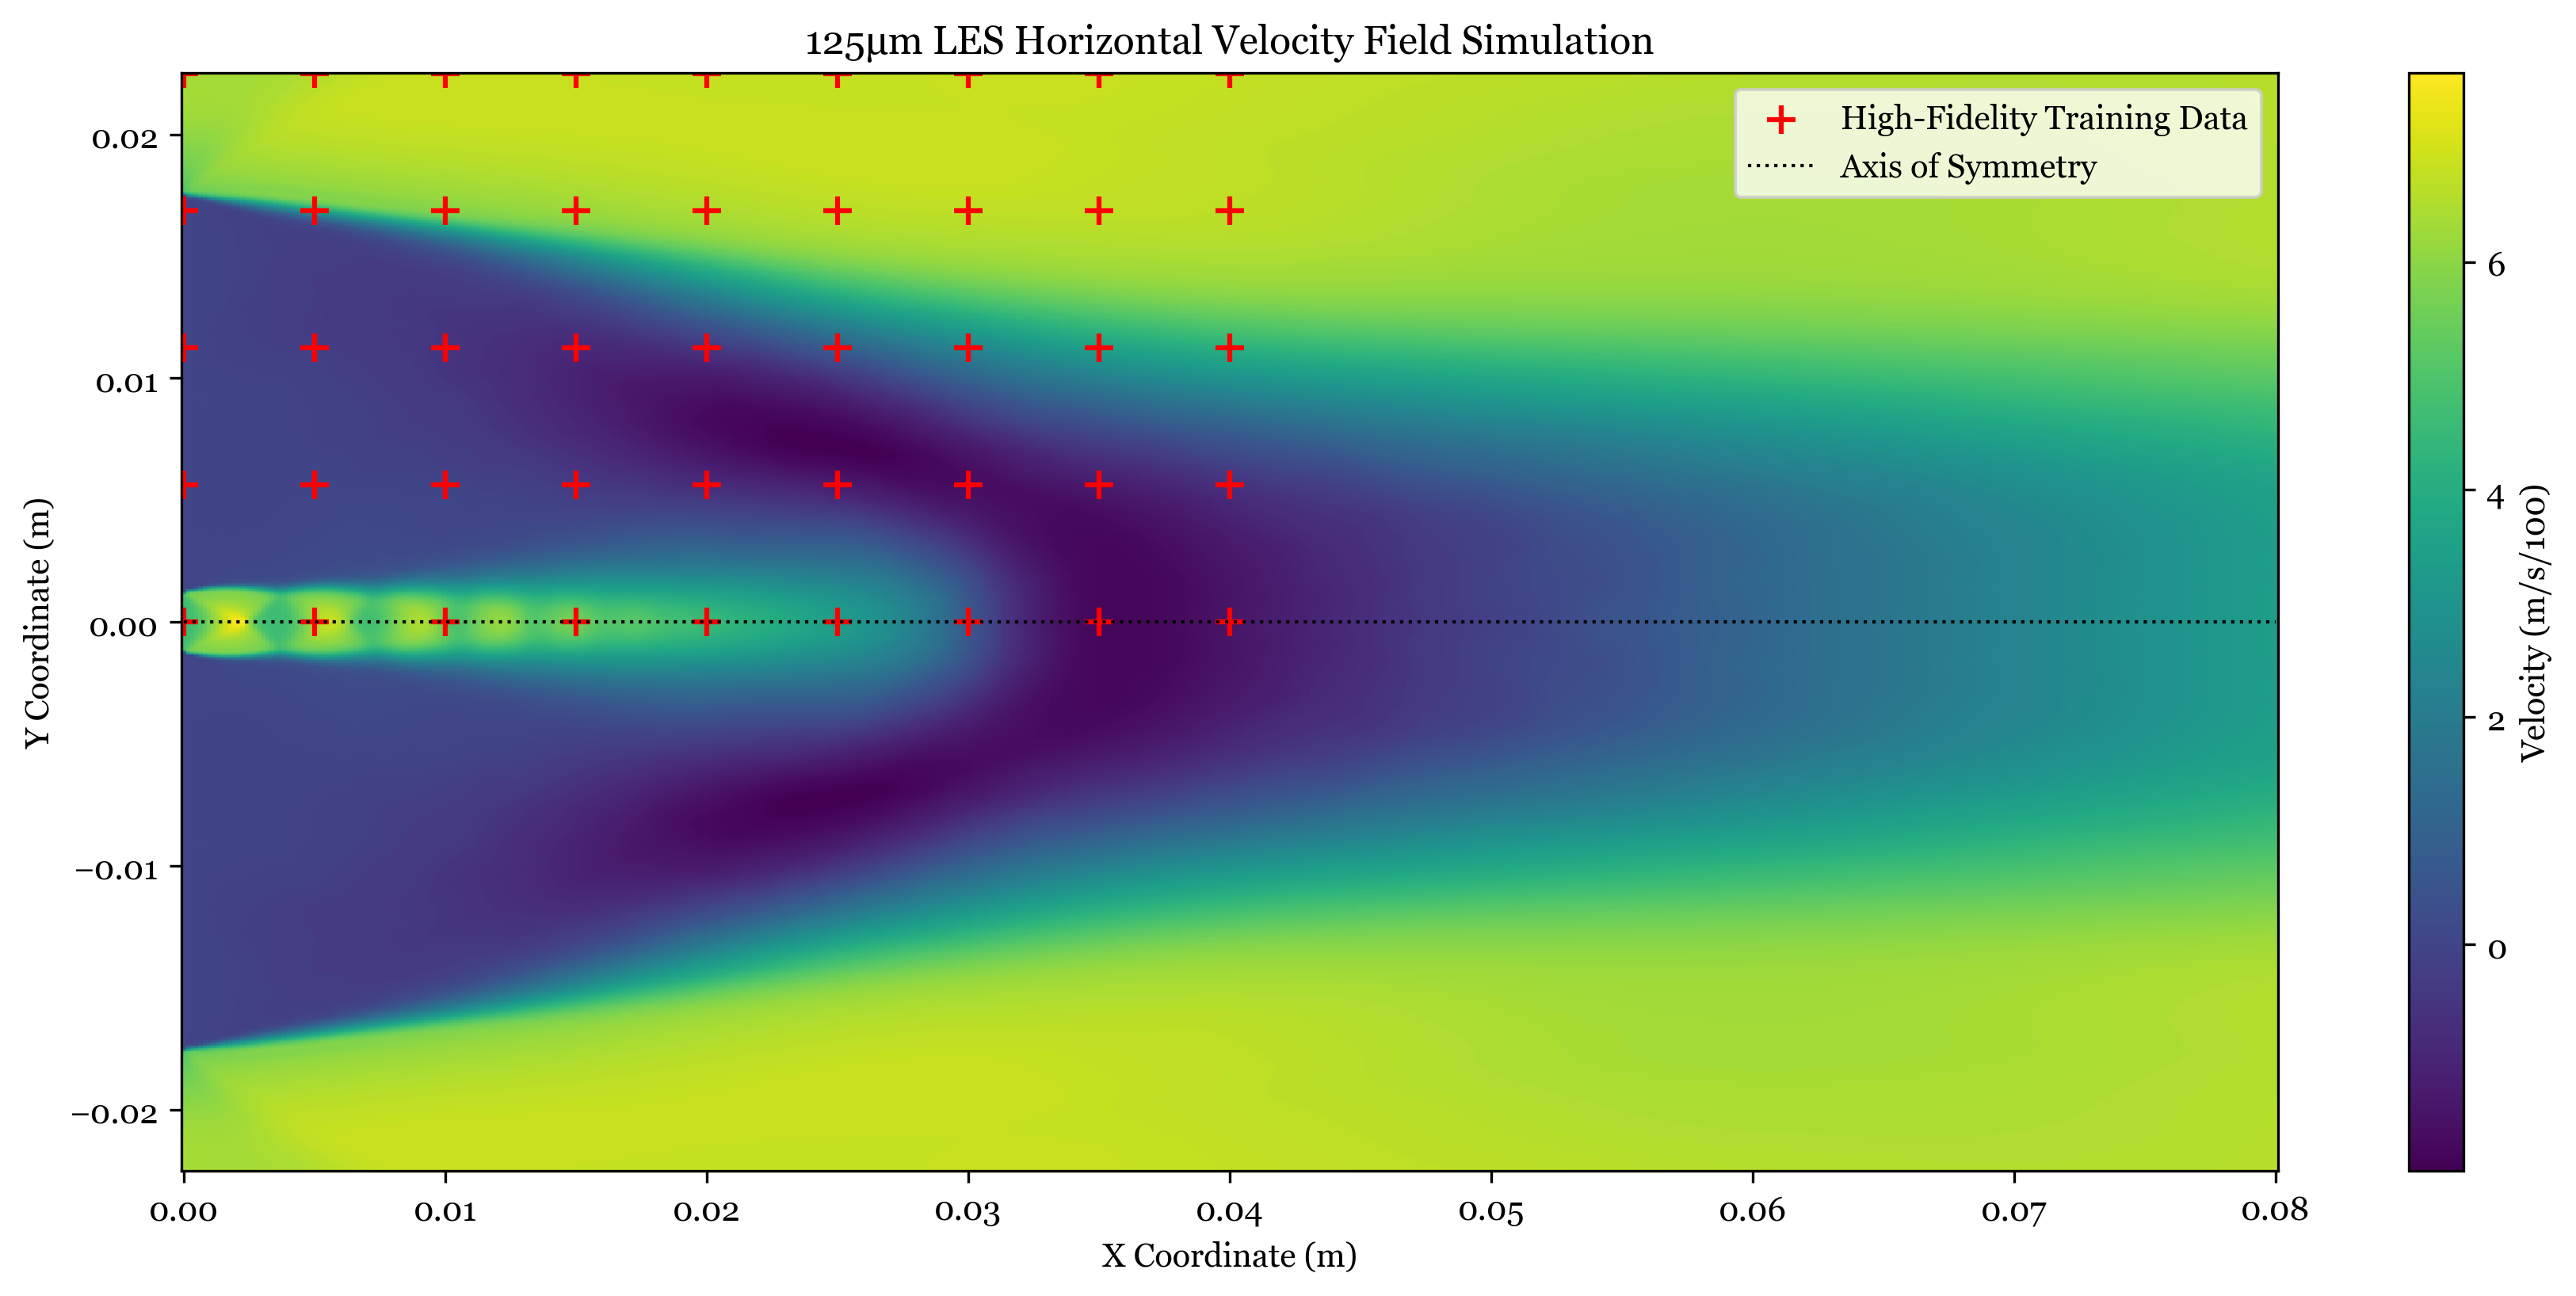

In [3]:
# Visualizing High-Fidelity training data 
plt.figure(figsize=(ratio * 4,6), dpi = 300)
X, Y, Z = to_grid(scaler.inverse_transform(data_dict[4]['X']), data_dict[4][target_qoi], N_partitions = 500)
plt.pcolormesh(X, Y, Z, cmap = 'viridis')

temp_X = np.copy(scaler.inverse_transform(data_dict[4]['X']))
temp_X[:,1] = -temp_X[:,1]
temp_Y = np.copy(data_dict[4][target_qoi])
X, Y, Z = to_grid(temp_X, temp_Y, N_partitions = 500)
plt.pcolormesh(X, Y, Z, cmap = 'viridis')

plt.colorbar(label = 'Velocity (m/s/100)')

plt.scatter(scaler.inverse_transform(Xtrain)[:,0], scaler.inverse_transform(Xtrain)[:,1], s = 75.0, c = 'red', label = "High-Fidelity Training Data", marker = '+')
plt.plot([0, 0.08], [0.0, 0.0], linestyle = 'dotted', linewidth =1.0, color = 'black', label = 'Axis of Symmetry')

plt.xlabel("X Coordinate (m)")
plt.ylabel("Y Coordinate (m)")
plt.title("125μm LES Horizontal Velocity Field Simulation")
plt.legend()

In [4]:
# Storing training and testing data
Xtest, Ytest = data_dict[4]['X'], data_dict[4][target_qoi]
data_dict[4]['X'], data_dict[4][target_qoi] = Xtrain, Ytrain

In [ ]:
# Determining which QoI will be output for hyperkriging model
for level in data_dict.keys():
    data_dict[level]['Y'] = np.copy(data_dict[level][target_qoi])

from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import HistGradientBoostingRegressor

U_KNN_models = {} 

# Creating features for high-fidelity regression
train_features = np.copy(Xtrain)
test_features = np.copy(Xtest)

for level in range(len(data_dict)-1):
    # Declaring new K Nearest Neighbors Classifier
    model = KNeighborsRegressor(n_neighbors = 10, weights = 'distance')
    
    # Fitting the model to the training data
    model.fit(data_dict[level]['X'], data_dict[level][target_qoi])

    # Storing the model in the dictionary
    U_KNN_models[level] = model

    # Making train and test predictions 
    train_pred, test_pred = model.predict(Xtrain), model.predict(Xtest)

    train_features = np.hstack((train_features, train_pred.reshape(-1,1)))
    test_features = np.hstack((test_features, test_pred.reshape(-1,1)))

Text(0, 0.5, 'Y Coordinate')

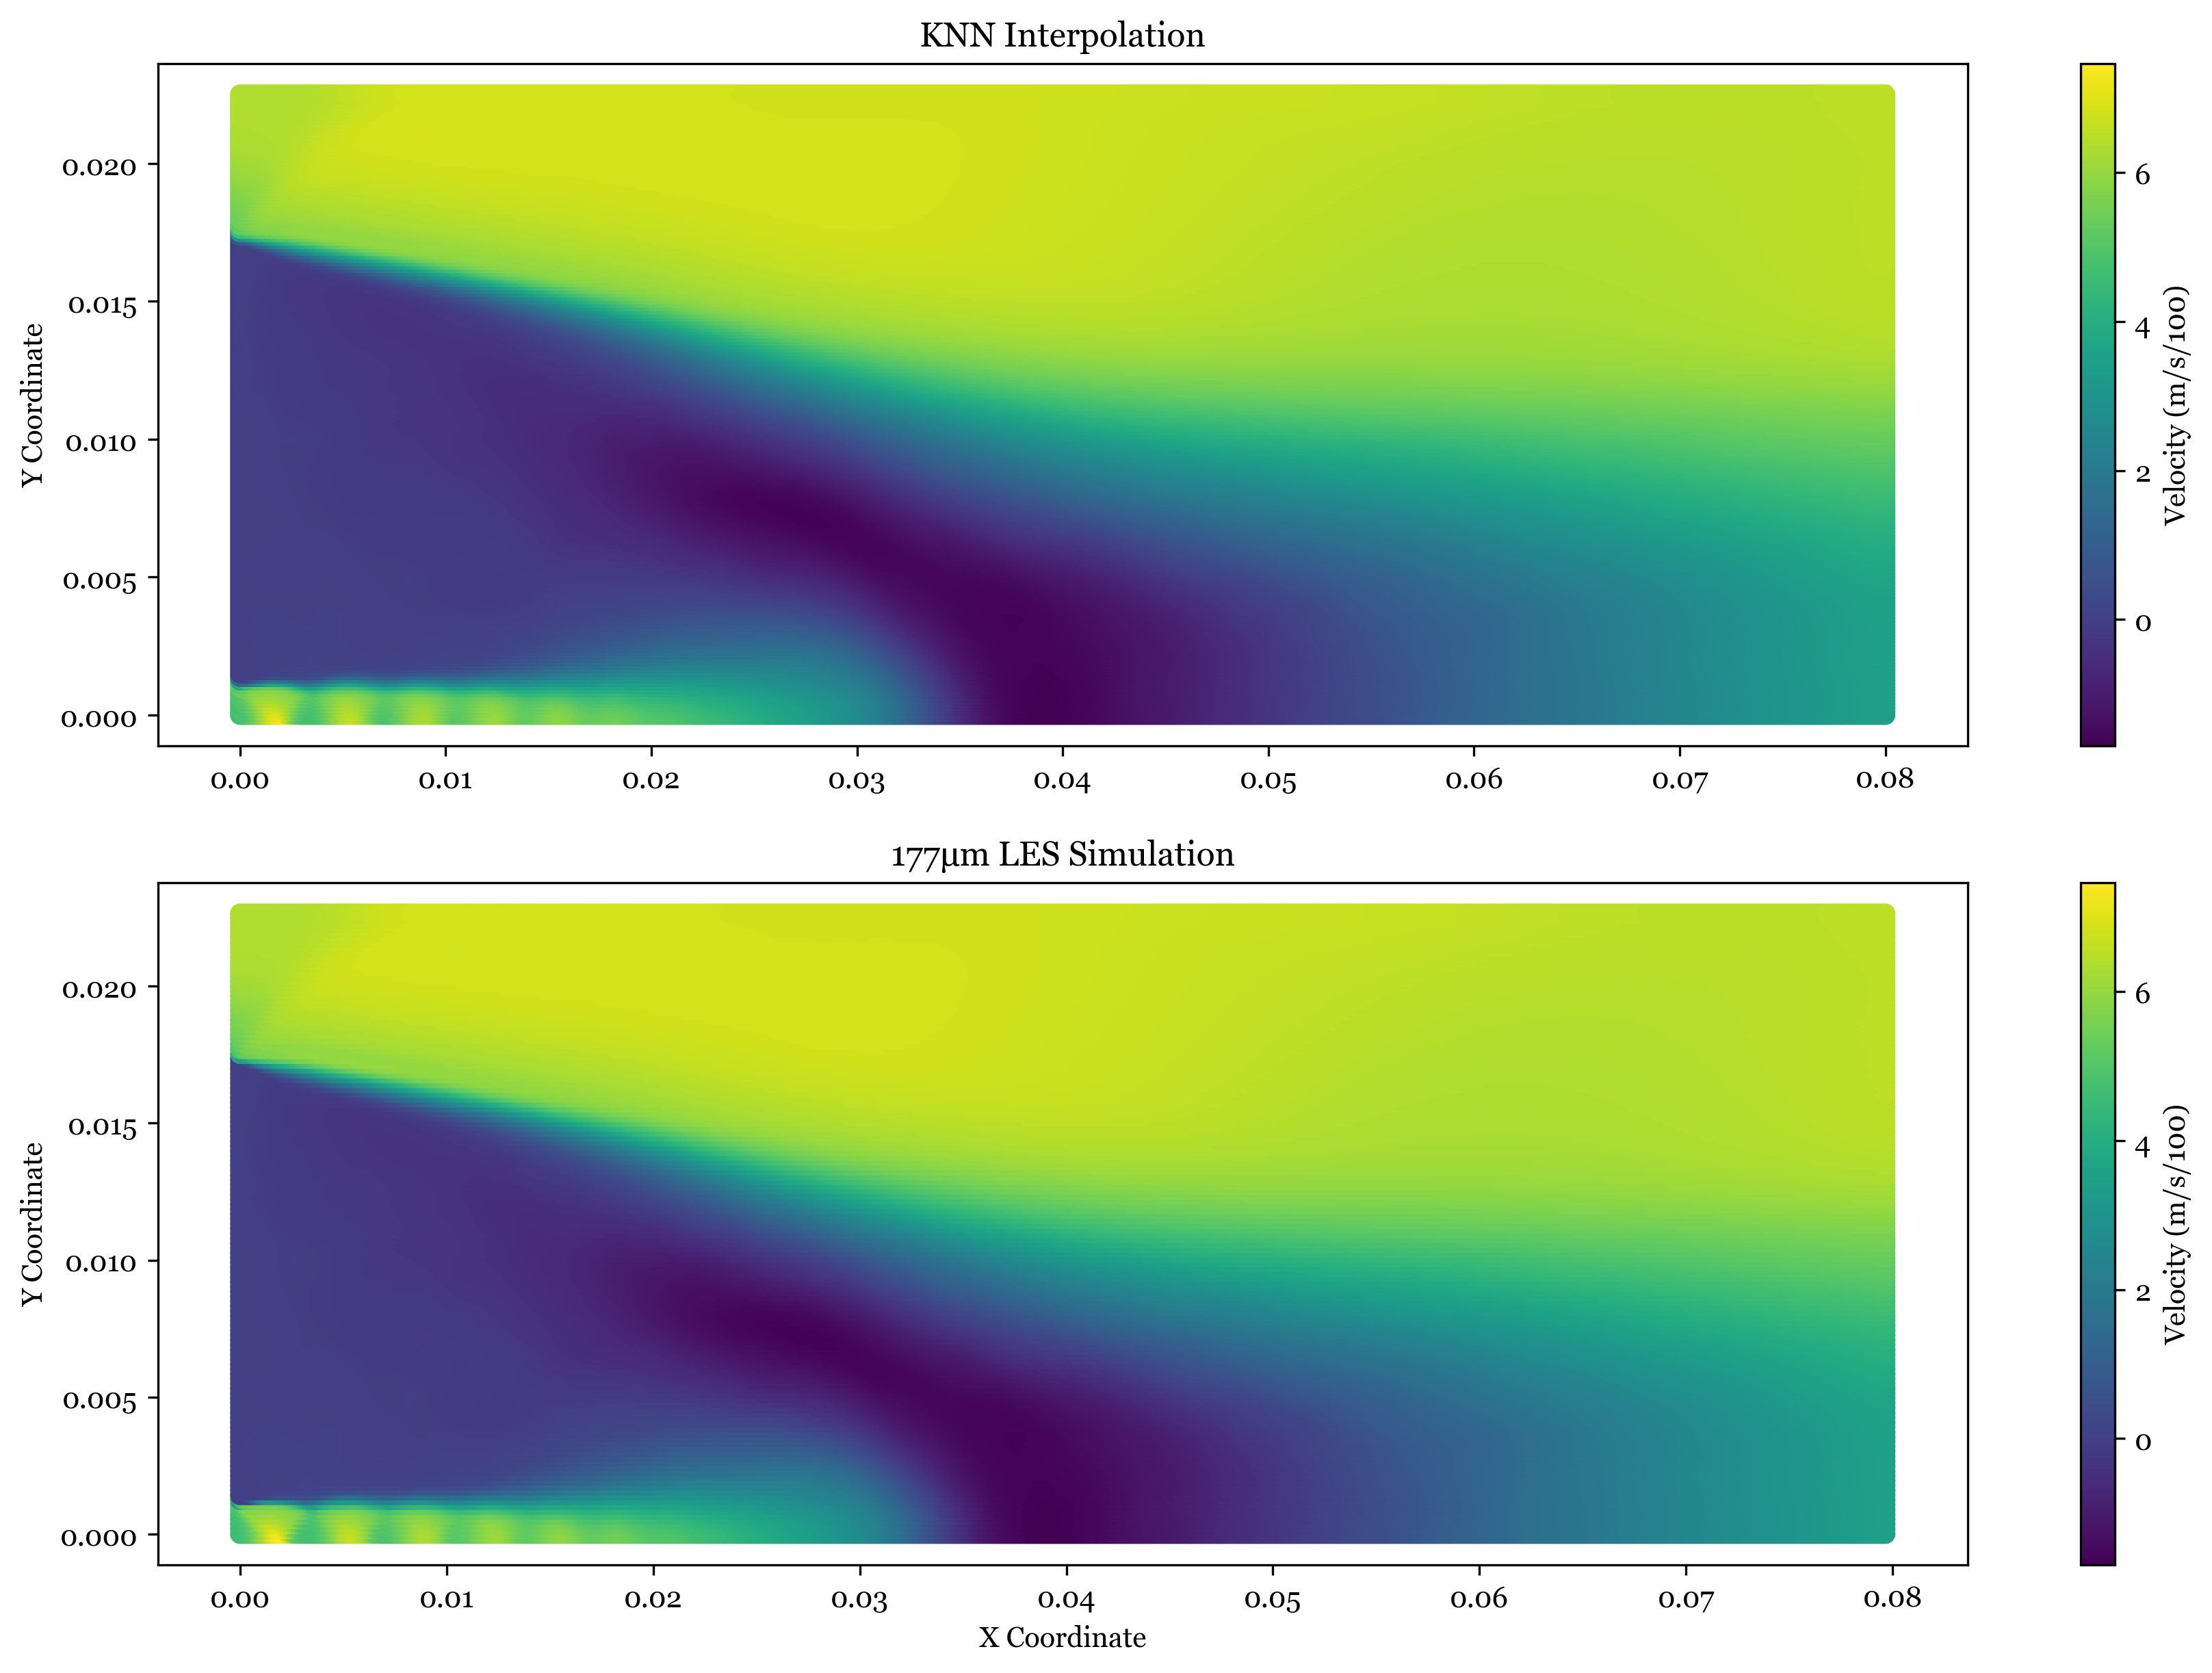

In [6]:
vmin = min(test_pred.min(), data_dict[3][target_qoi].min())
vmax = max(test_pred.max(), data_dict[3][target_qoi].max())

plt.figure(figsize=(4*ratio, 4.75*2), dpi=300)

# First plot
plt.subplot(2, 1, 1)
plt.scatter(
    scaler.inverse_transform(Xtest)[:, 0],
    scaler.inverse_transform(Xtest)[:, 1],
    c=test_pred,
    cmap='viridis',
    vmin=vmin,
    vmax=vmax
)
plt.title("KNN Interpolation")
plt.colorbar(label='Velocity (m/s/100)')
plt.ylabel("Y Coordinate")

# Second plot
plt.subplot(2, 1, 2)
plt.scatter(
    scaler.inverse_transform(data_dict[3]['X'])[:, 0],
    scaler.inverse_transform(data_dict[3]['X'])[:, 1],
    c=data_dict[3][target_qoi],
    cmap='viridis',
    vmin=vmin,
    vmax=vmax
)
plt.colorbar(label='Velocity (m/s/100)')
plt.title("177μm LES Simulation")
plt.xlabel("X Coordinate")
plt.ylabel("Y Coordinate")

In [140]:
# Creating a high-fidelity Kriging model with multi-fidelity features
hk_model = GP(train_features, Ytrain, RBF, Linear, noise_var = 1e-5, epsilon = 1e-12, max_cond = 1e5, calibrate=True)
optimizer = Momentum(hk_model, neg_mll, beta = 0.9)
optimizer.latin_hypercube_init('k_param', 50, min=-50, max = 50)

Calibrated white noise variance: 1.7187e-03
Best Objective Value: -6.3173e+00


In [74]:
optimizer.run(2e-4, 10000, ['k_param', 'm_param', 'noise_var'])

100%|██████████| 10000/10000 [02:12<00:00, 75.20it/s, Loss: -3.1610e+01]


In [151]:
koh = DeltaGP(Xtrain, Ytrain, train_features[:,-1], RBF, Constant, calibrate = True, noise_var = 1e-3, epsilon = 1e-12)
koh_optimizer = Momentum(koh, delta_neg_mll, beta = 0.9)
#koh_optimizer.latin_hypercube_init('k_param', 100, min=-100, max = 100)

Calibrated white noise variance: 1.0000e-03


In [153]:
koh_optimizer.beta = 0.9
koh_optimizer.run(1e-3, 500, ['k_param', 'rho'])

100%|██████████| 500/500 [00:06<00:00, 82.15it/s, Loss: 2.5727e+01]


In [139]:
from sklearn.metrics import mean_absolute_error as MAE 
hk_mean, _ = hk_model.predict(test_features, full_cov = False) 
koh_mean, _ = koh.predict(Xtest, full_cov = False) 
print("Hyperkriging MAE:    %.5f" % MAE(Ytest[Xtest[:,0] <= (x_partitions-1) * grid_spacing], hk_mean[Xtest[:,0] <= (x_partitions-1) * grid_spacing]))
print("Kennedy OH MAE:      %.5f" % MAE(Ytest[Xtest[:,0] <= (x_partitions-1) * grid_spacing], koh_mean[Xtest[:,0] <= (x_partitions-1) * grid_spacing]))
print("177 MAE:             %.5f" % MAE(Ytest[Xtest[:,0] <= (x_partitions-1) * grid_spacing], test_features[Xtest[:,0] <= (x_partitions-1) * grid_spacing, 5]))
print("250 MAE:             %.5f" % MAE(Ytest[Xtest[:,0] <= (x_partitions-1) * grid_spacing], test_features[Xtest[:,0] <= (x_partitions-1) * grid_spacing, 4]))
print("500 MAE:             %.5f" % MAE(Ytest[Xtest[:,0] <= (x_partitions-1) * grid_spacing], test_features[Xtest[:,0] <= (x_partitions-1) * grid_spacing, 3]))
print("RANS MAE:            %.5f" % MAE(Ytest[Xtest[:,0] <= (x_partitions-1) * grid_spacing], test_features[Xtest[:,0] <= (x_partitions-1) * grid_spacing, 2]))

Hyperkriging MAE:    0.10639
Kennedy OH MAE:      3.09318
177 MAE:             0.23540
250 MAE:             0.43286
500 MAE:             0.69406
RANS MAE:            0.41381


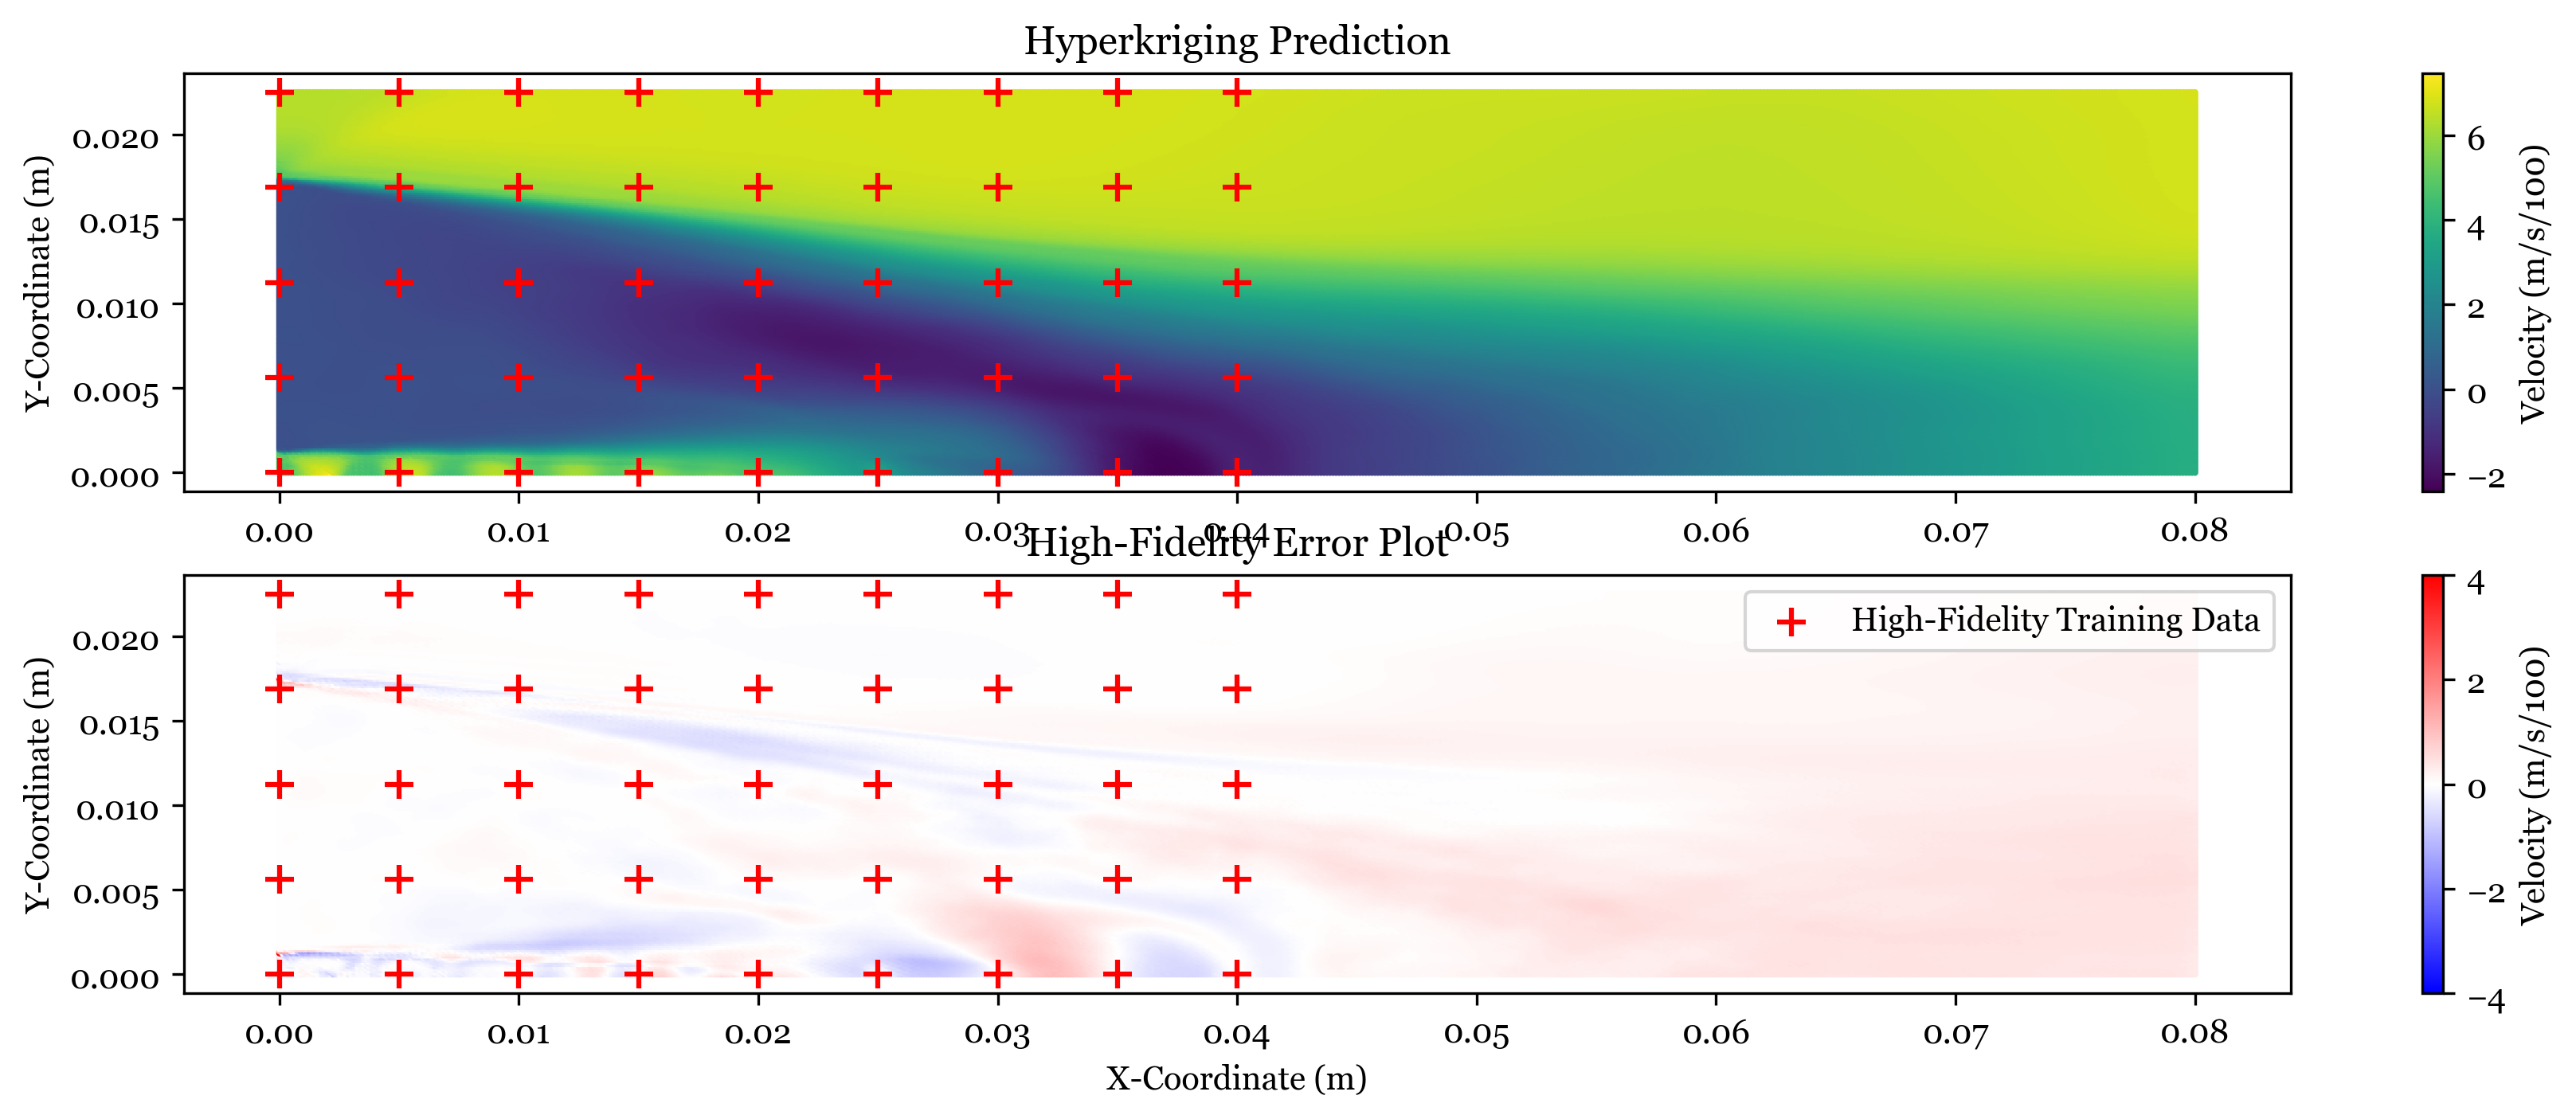

In [76]:
# Making predictions on test features
plt.figure(figsize=(4*ratio,2.5*2), dpi = 300)

plt.subplot(2,1,1)
plt.title("Hyperkriging Prediction")

plt.scatter(scaler.inverse_transform(Xtest)[:,0], scaler.inverse_transform(Xtest)[:,1], c = hk_mean, cmap = 'viridis', s = 1.0)
plt.colorbar(label = "Velocity (m/s/100)")
plt.scatter(scaler.inverse_transform(Xtrain)[:,0], scaler.inverse_transform(Xtrain)[:,1], c = 'red', s = 75, marker = '+', label = "High-Fidelity Training Data")
plt.ylabel("Y-Coordinate (m)")

plt.subplot(2,1,2)
from matplotlib.colors import TwoSlopeNorm
diff = hk_mean - Ytest
norm = TwoSlopeNorm(vmin=-4, vcenter=0, vmax=4)
im = plt.scatter(scaler.inverse_transform(Xtest)[:,0], scaler.inverse_transform(Xtest)[:,1], c = hk_mean - Ytest, cmap = 'bwr', norm = norm, s = 1.0)
cbar = plt.colorbar(label = "Velocity (m/s/100)")
plt.title("High-Fidelity Error Plot")
plt.scatter(scaler.inverse_transform(Xtrain)[:,0], scaler.inverse_transform(Xtrain)[:,1], c = 'red', s = 75, marker = '+', label = "High-Fidelity Training Data")
plt.ylabel("Y-Coordinate (m)")
plt.xlabel("X-Coordinate (m)")
plt.legend()

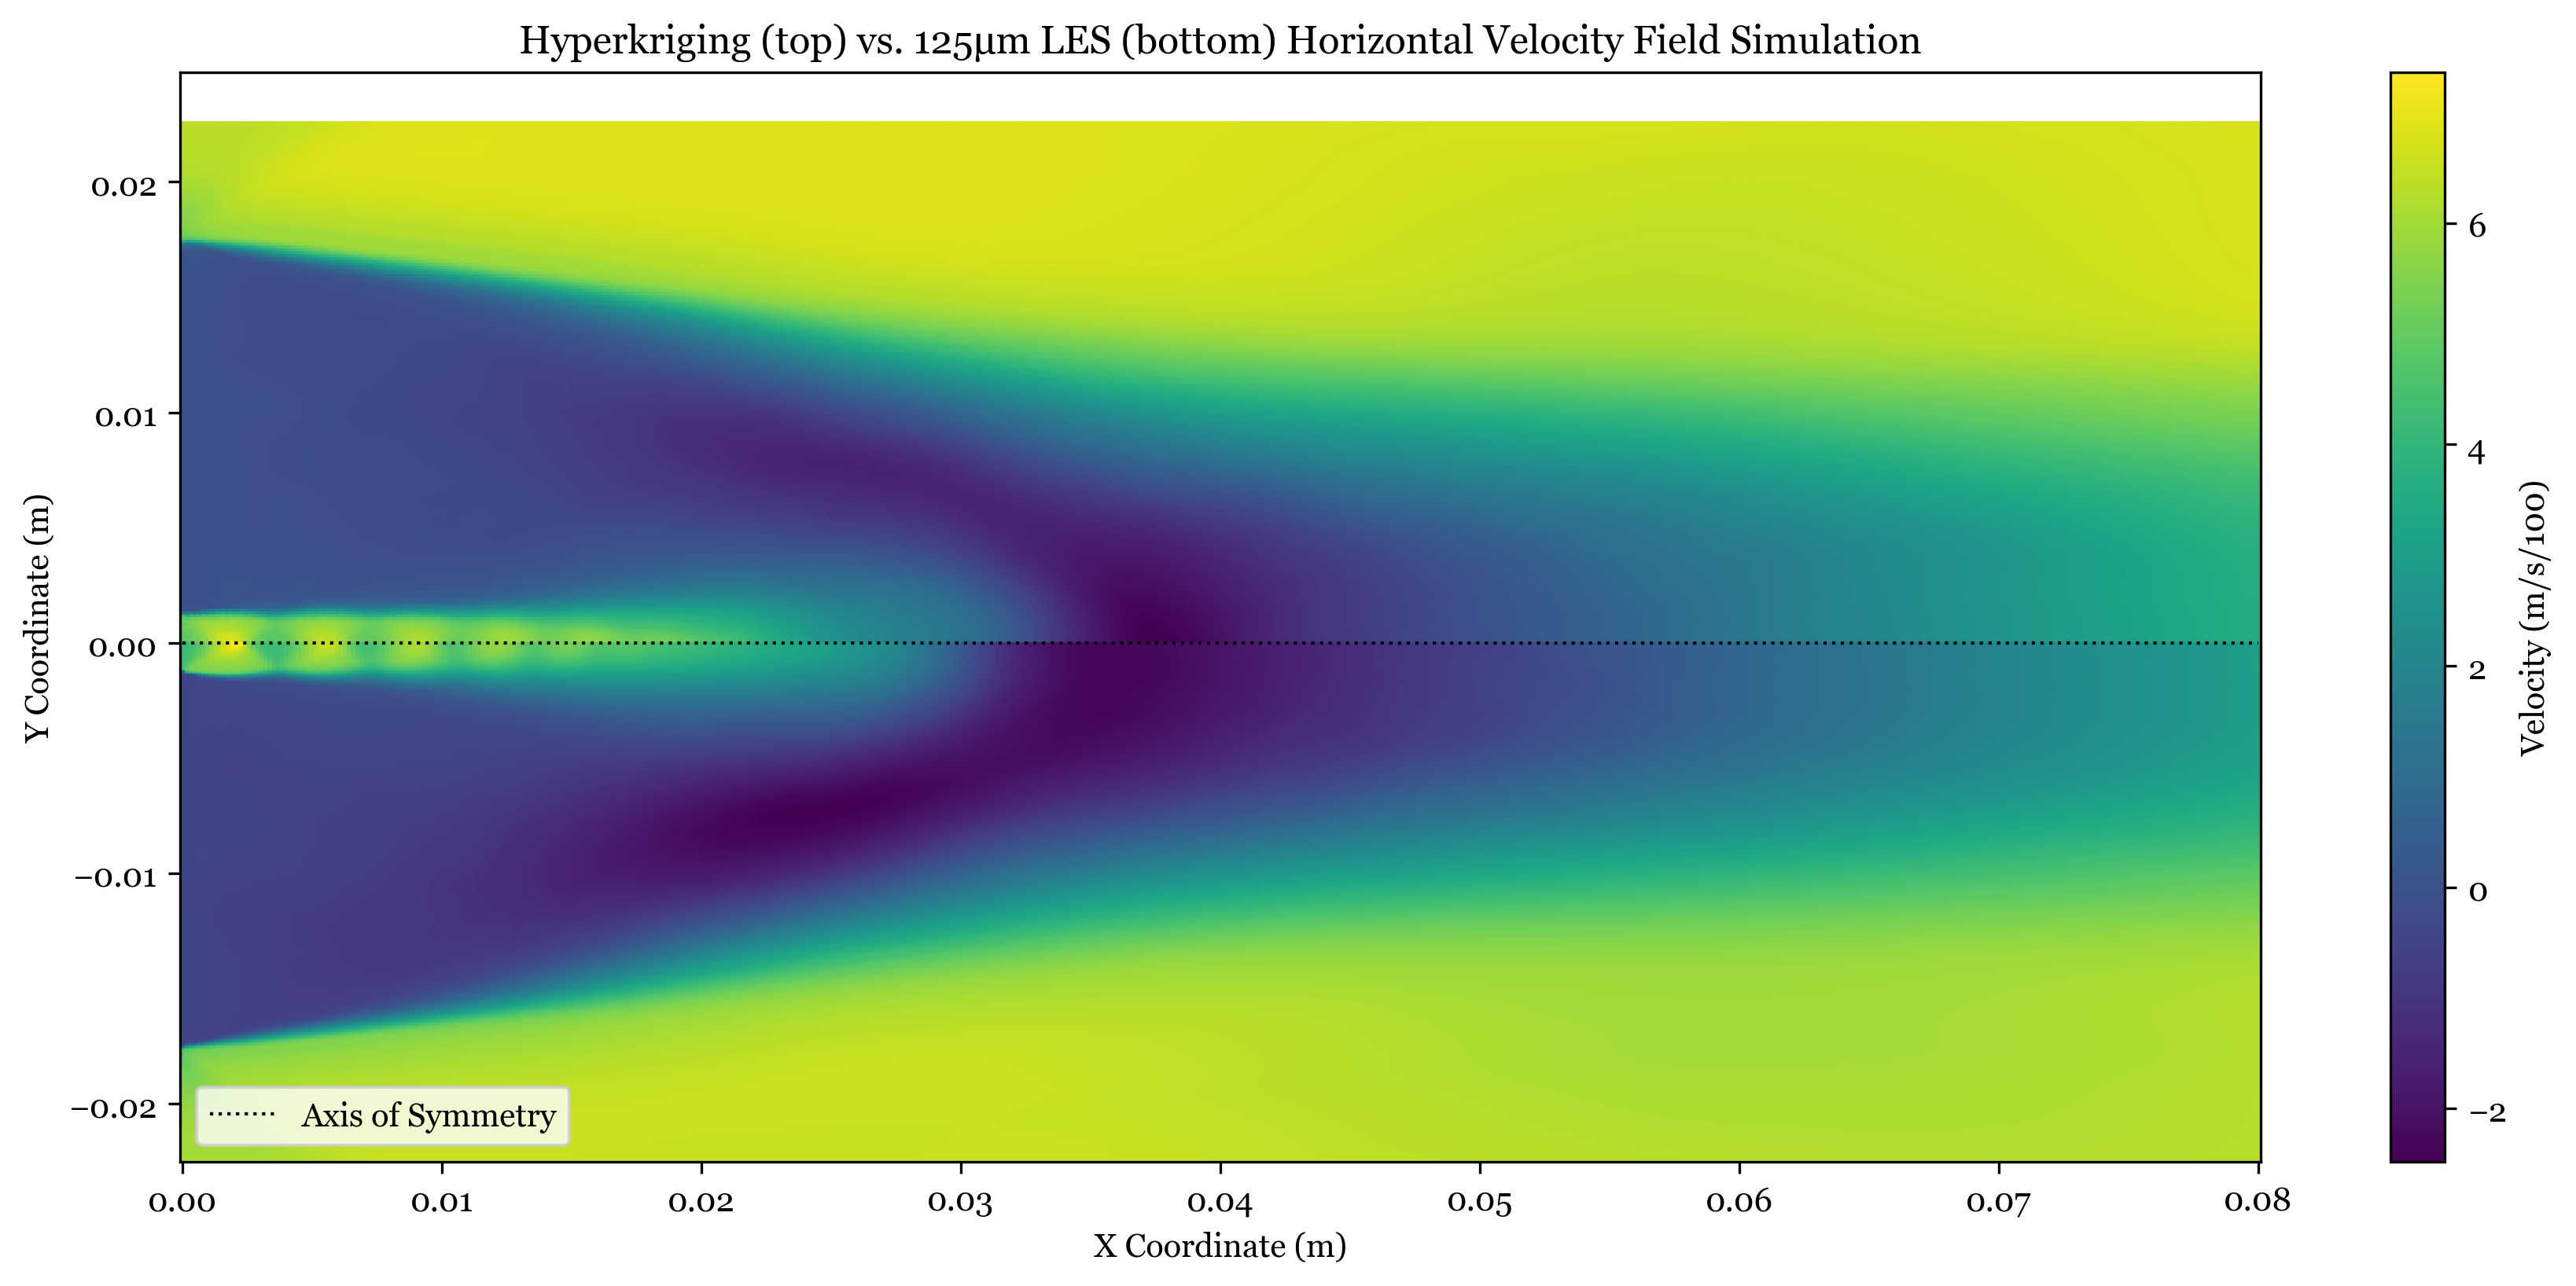

In [45]:
# Visualizing High-Fidelity training data 
plt.figure(figsize=(ratio * 4,6), dpi = 300)


plt.scatter(scaler.inverse_transform(Xtest)[:,0], scaler.inverse_transform(Xtest)[:,1], c = hk_mean, cmap = 'viridis', s = 1.0)
plt.colorbar(label = "Velocity (m/s/100)")


X, Y, Z = to_grid(temp_X, temp_Y, N_partitions = 500)
plt.pcolormesh(X, Y, Z, cmap = 'viridis')

plt.plot([0, 0.08], [0.0, 0.0], linestyle = 'dotted', linewidth =1.0, color = 'black', label = 'Axis of Symmetry')

plt.xlabel("X Coordinate (m)")
plt.ylabel("Y Coordinate (m)")
plt.title("Hyperkriging (top) vs. 125μm LES (bottom) Horizontal Velocity Field Simulation")
plt.legend()

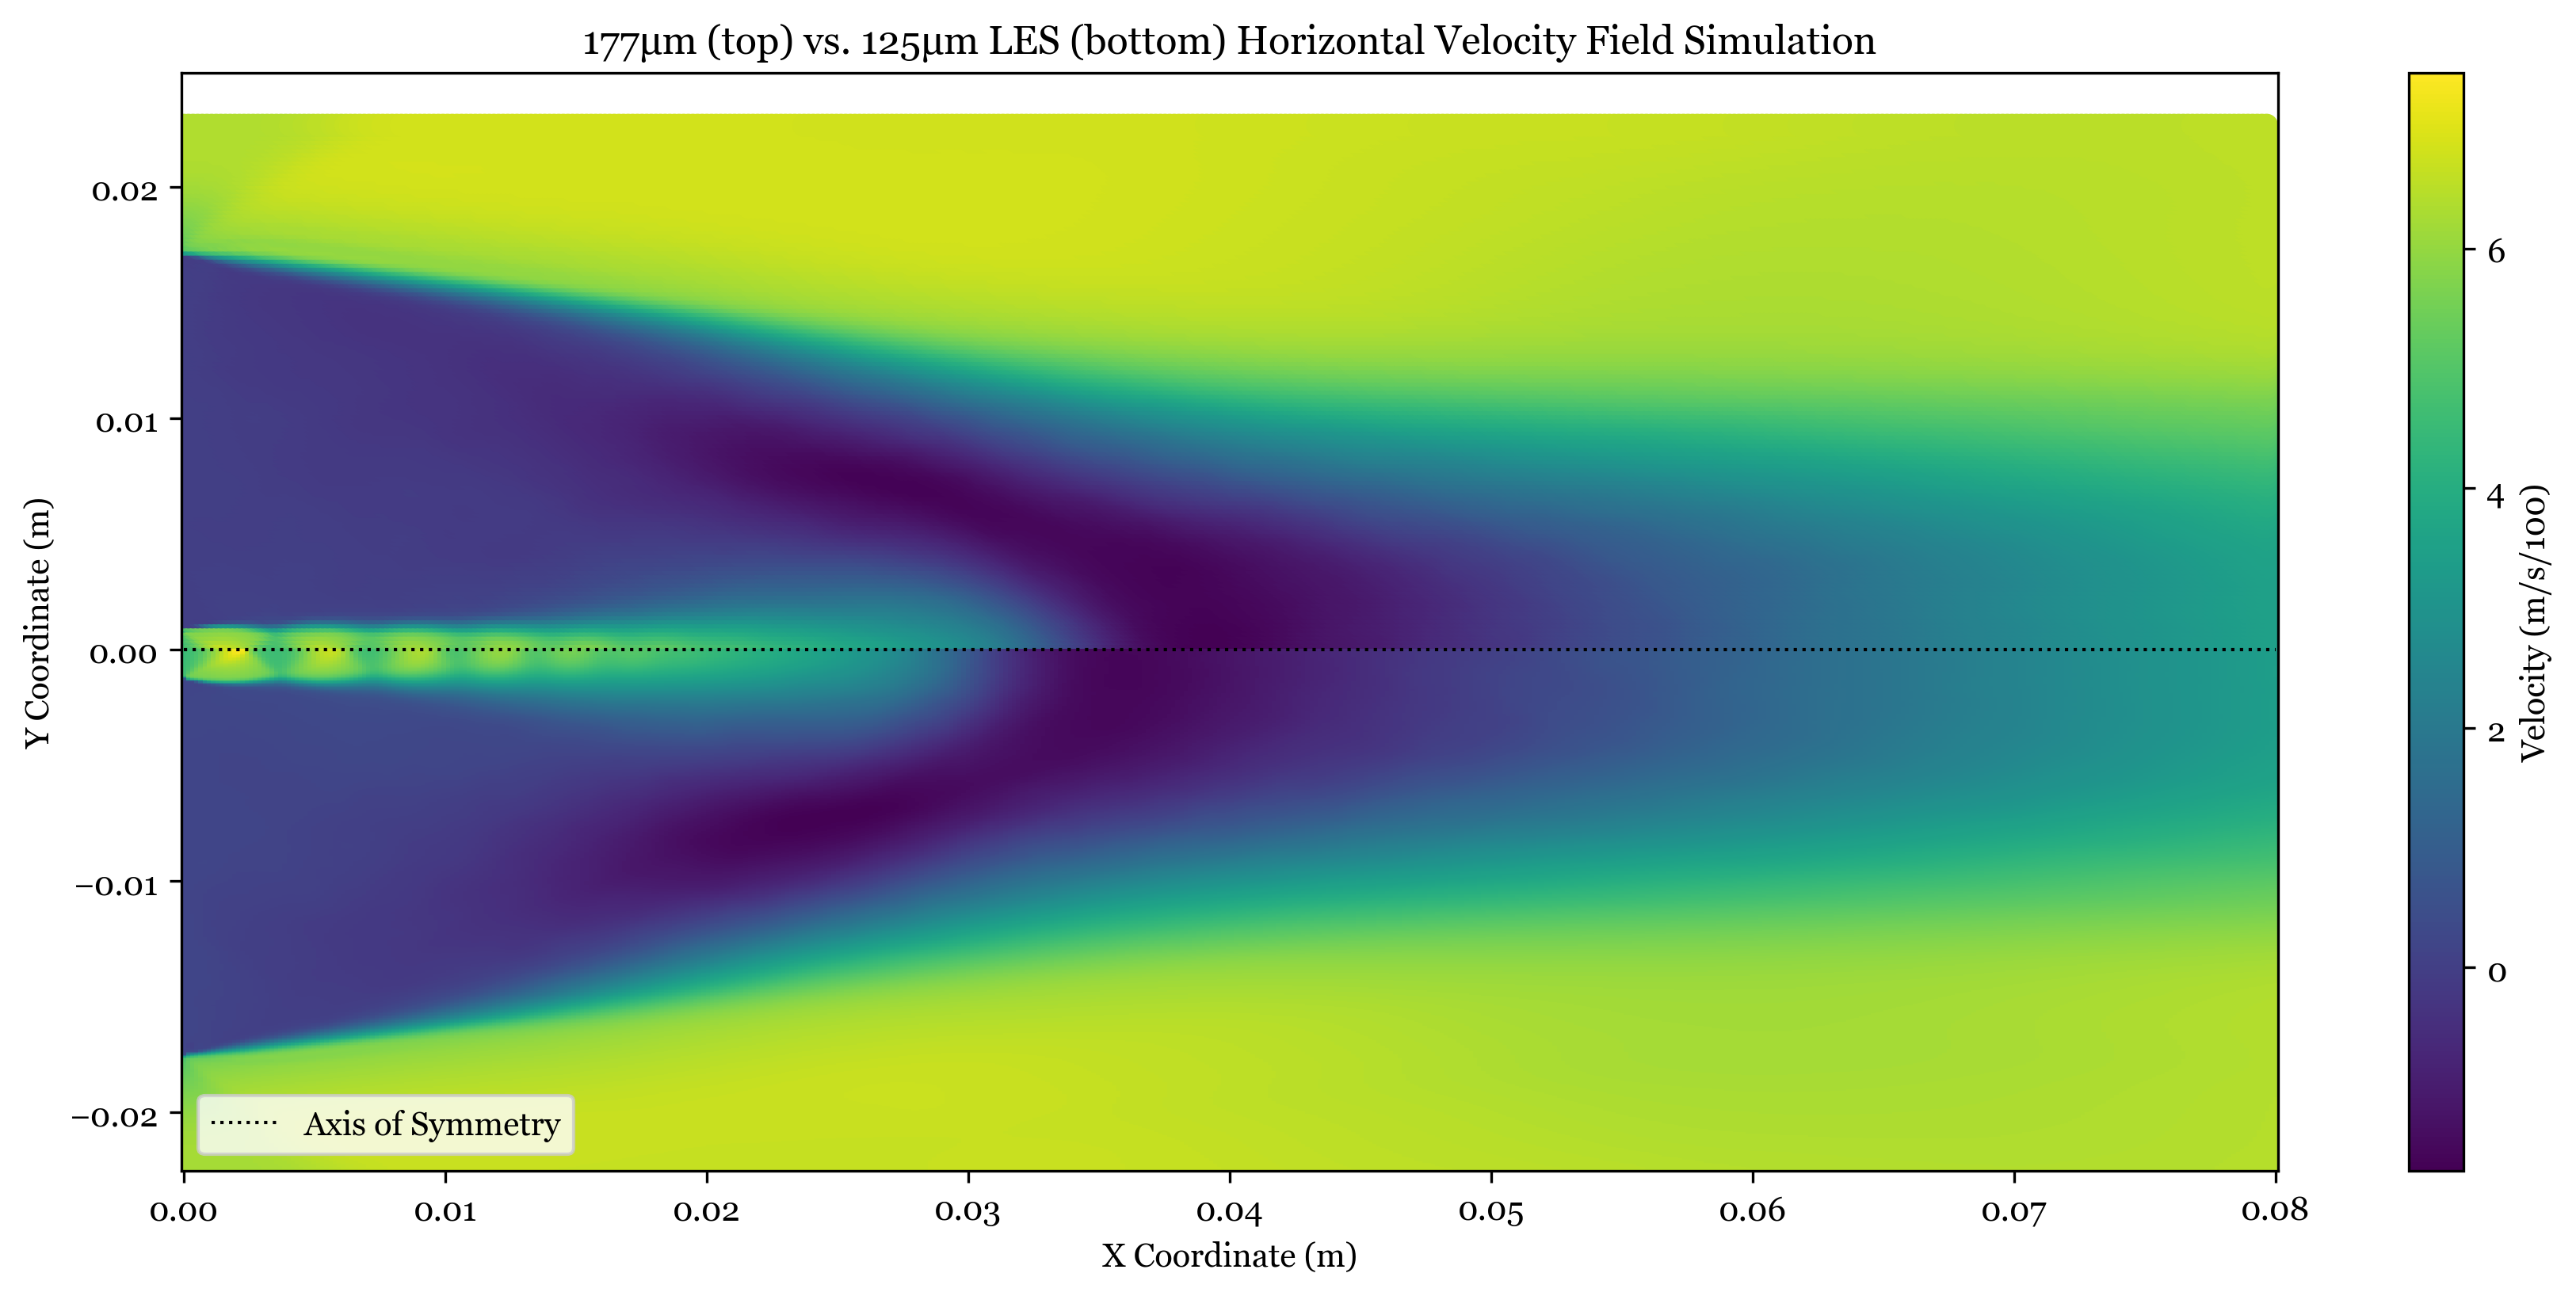

In [46]:
# Visualizing High-Fidelity training data 
plt.figure(figsize=(ratio * 4,6), dpi = 300)


plt.scatter(
    scaler.inverse_transform(data_dict[3]['X'])[:, 0],
    scaler.inverse_transform(data_dict[3]['X'])[:, 1],
    c=data_dict[3][target_qoi],
    cmap='viridis',
    vmin=vmin,
    vmax=vmax
)
plt.colorbar(label = "Velocity (m/s/100)")


X, Y, Z = to_grid(temp_X, temp_Y, N_partitions = 500)
plt.pcolormesh(X, Y, Z, cmap = 'viridis')

plt.plot([0, 0.08], [0.0, 0.0], linestyle = 'dotted', linewidth =1.0, color = 'black', label = 'Axis of Symmetry')

plt.xlabel("X Coordinate (m)")
plt.ylabel("Y Coordinate (m)")
plt.title("177μm (top) vs. 125μm LES (bottom) Horizontal Velocity Field Simulation")
plt.legend()

In [53]:
kr_model = GP(Xtrain, Ytrain, RBF, Linear, kernel_params = jnp.ones(3), noise_var = 1e-9, epsilon = 1e-8, max_cond = 1e5, calibrate=True)
kr_optimizer = Momentum(kr_model, neg_mll, beta = 0.9)
kr_optimizer.latin_hypercube_init('k_param', 50, min=-50, max = 50)

Calibrated white noise variance: 4.1959e-03
Best Objective Value: 1.0801e+02


In [55]:
kr_optimizer.run(1e-2, 1000, ['k_param', 'm_param', 'noise_var'])

100%|██████████| 1000/1000 [00:12<00:00, 82.33it/s, Loss: 1.0799e+02]


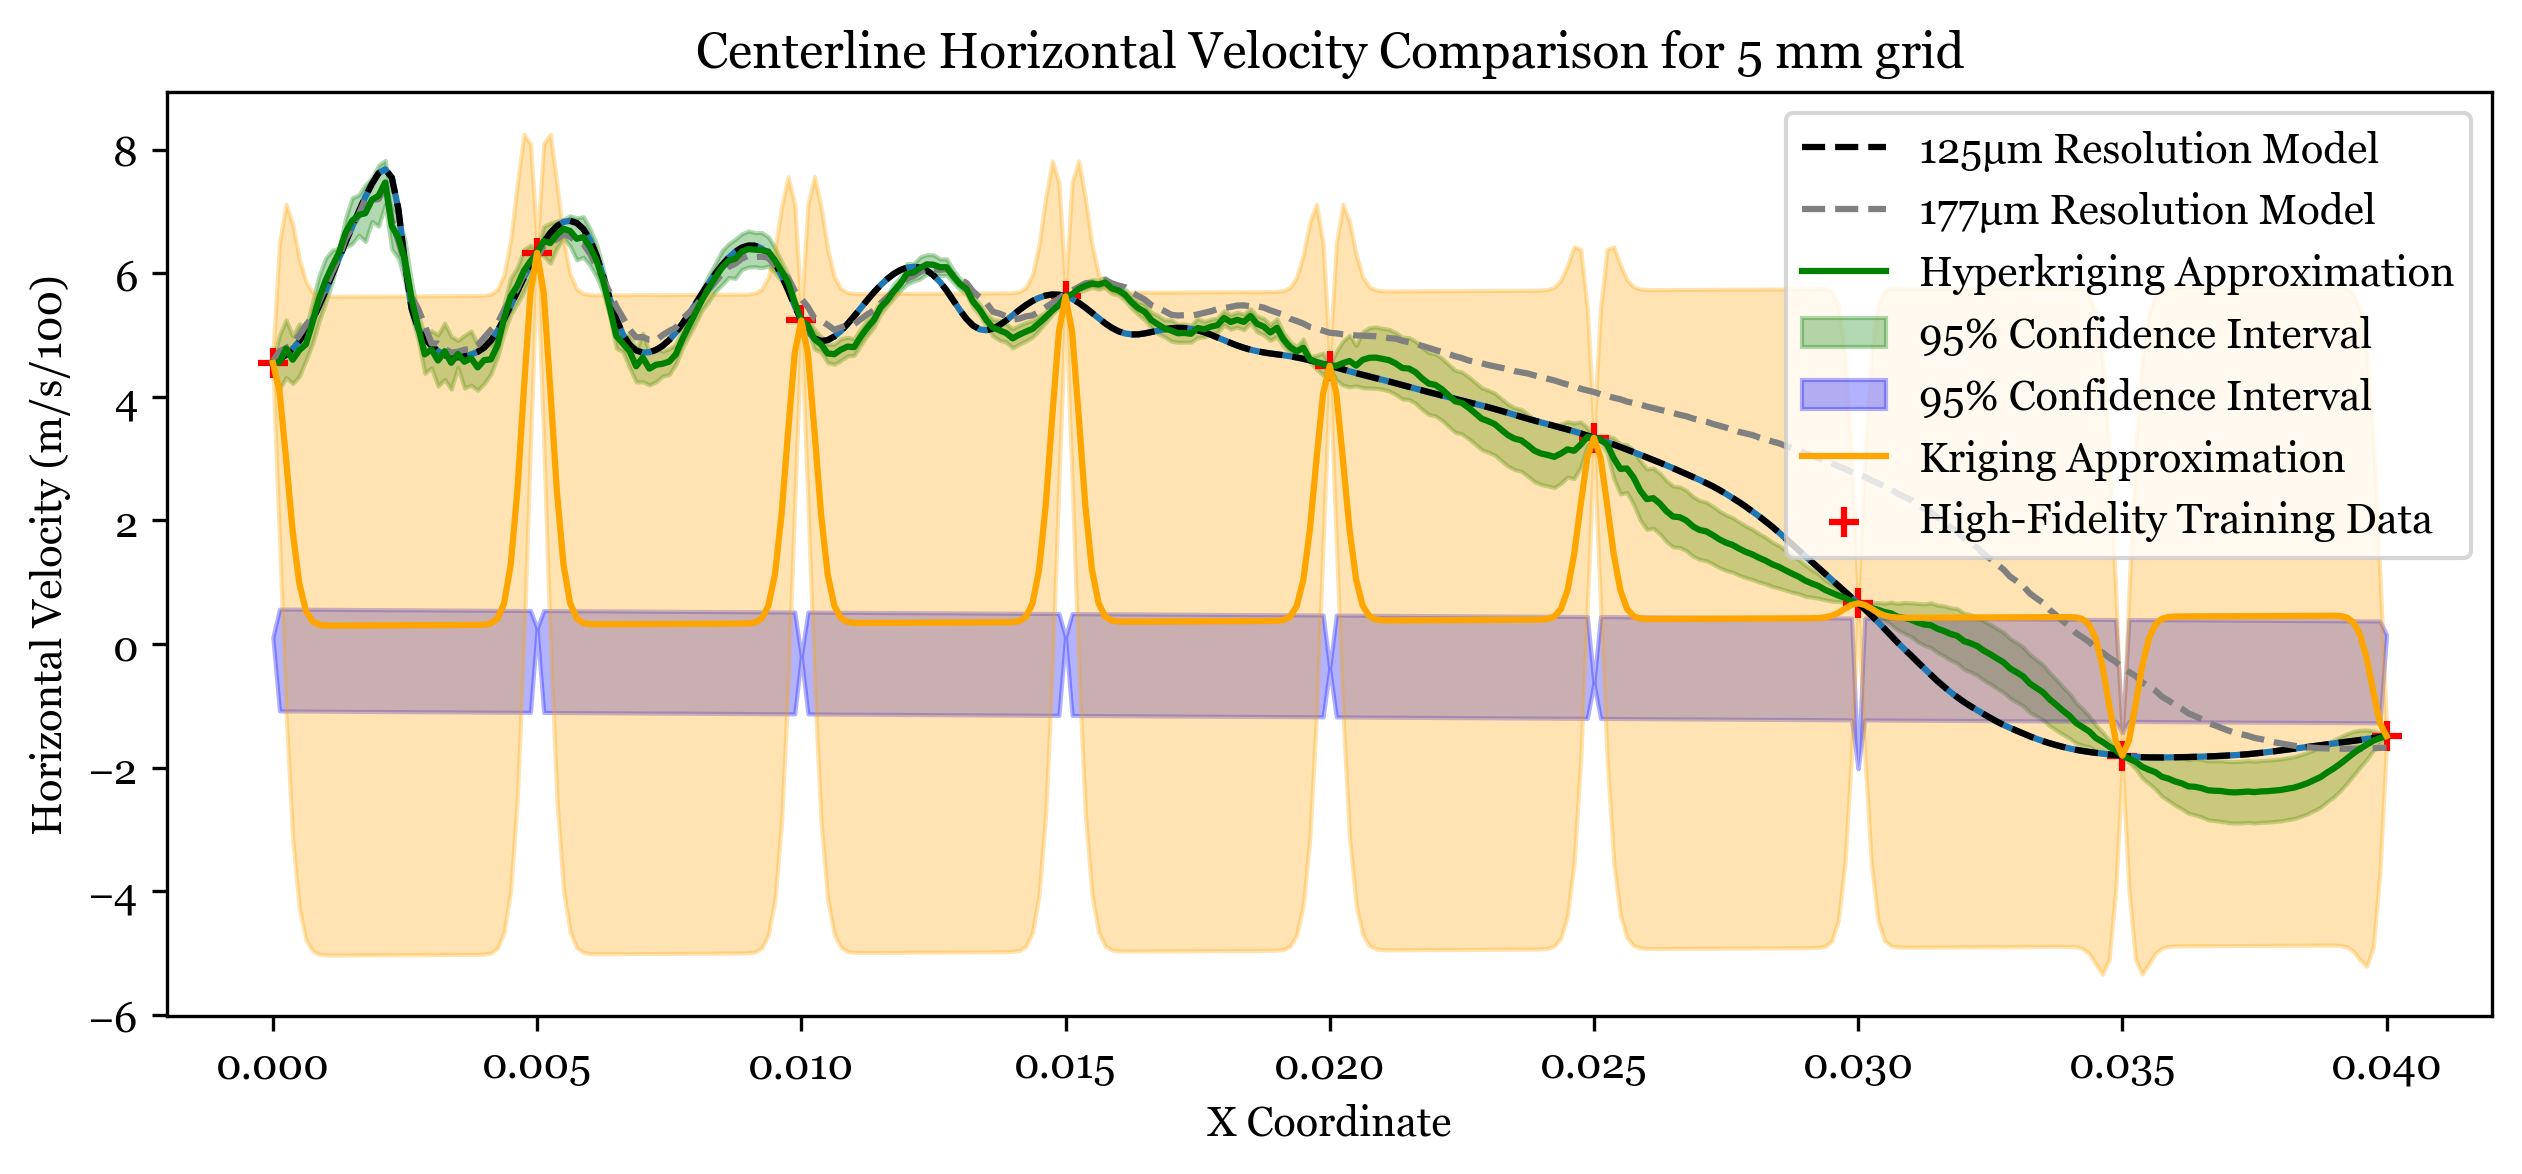

In [97]:
criterion = (Xtest[:,1] == Xtest[:,1].min()) & (scaler.inverse_transform(Xtest)[:,0] <= (x_partitions-1) * grid_spacing)
Xjet, Yjet, Fjet = Xtest[criterion,:], Ytest[criterion], test_features[criterion, :]

hk_jet, cov_jet = hk_model.predict(Fjet)
conf = 2*np.sqrt(np.diag(cov_jet))

koh_jet, koh_cov_jet = koh.predict(Xjet)
koh_conf = 2*np.sqrt(np.diag(koh_cov_jet))

kr_mean, kr_cov = kr_model.predict(Xjet)
kr_conf = 2 * np.sqrt(np.diag(kr_cov))

plt.figure(figsize=(10,4), dpi = 300)
plt.plot(scaler.inverse_transform(Xjet)[:,0], Yjet)
plt.plot(scaler.inverse_transform(Xjet)[:,0], Yjet, label = "125μm Resolution Model", color = 'black', linestyle = 'dashed')
plt.plot(scaler.inverse_transform(Xjet)[:,0], test_features[criterion,5], label = "177μm Resolution Model", color = 'gray', linestyle = 'dashed')
plt.plot(scaler.inverse_transform(Xjet)[:,0], hk_jet, label = "Hyperkriging Approximation", color = 'green')
plt.fill_between(scaler.inverse_transform(Xjet)[:,0], hk_jet - conf, hk_jet + conf, color = 'green', alpha = 0.3, label = "95% Confidence Interval")
plt.fill_between(scaler.inverse_transform(Xjet)[:,0], koh_jet - koh_conf, koh_jet + koh_conf, color = 'blue', alpha = 0.3, label = "95% Confidence Interval")

plt.plot(scaler.inverse_transform(Xjet)[:,0], kr_mean, label = "Kriging Approximation", color = 'orange')
plt.fill_between(scaler.inverse_transform(Xjet)[:,0], kr_mean - kr_conf, kr_mean + kr_conf, color = 'orange', alpha = 0.3)
plt.scatter(scaler.inverse_transform(Xtrain)[Xtrain[:,1] == Xtrain[:,1].min(), 0], Ytrain[Xtrain[:,1] == Xtrain[:,1].min()], marker = '+', color = 'red', label = 'High-Fidelity Training Data', s = 50.0)
plt.xlabel("X Coordinate")
plt.ylabel("Horizontal Velocity (m/s/100)")
plt.title("Centerline Horizontal Velocity Comparison for %d mm grid" % (grid_spacing * 1000))
plt.legend()

In [67]:
print("RANS MAE:            %.5f" % MAE(Yjet, test_features[criterion,2]))
print("500 Resolution  MAE: %.5f" % MAE(Yjet, test_features[criterion,3]))
print("250 Resolution  MAE: %.5f" % MAE(Yjet, test_features[criterion,4]))
print("177 Resolution  MAE: %.5f" % MAE(Yjet, test_features[criterion,5]))
print("Hyperkriging MAE:    %.5f" % MAE(Yjet, hk_jet))
print("Kriging MAE:         %.5f" % MAE(Yjet, kr_mean))

RANS MAE:            1.03860
500 Resolution  MAE: 1.44811
250 Resolution  MAE: 1.51564
177 Resolution  MAE: 0.70617
Hyperkriging MAE:    0.33928
Kriging MAE:         3.21820


In [27]:
import sympy as sp 

x, xp, s, t, tp = sp.symbols("x x\' \sigma t t\'")

e1 = sp.Eq(1/s - (t-tp)**2 / s**2, 4 / (1 - x)(1-xp))

TypeError: 'Add' object is not callable